In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from statsmodels.stats.libqsturng import qsturng
import Orange
import itertools

In [3]:
#path = '../../output/20160201-rf2'
path = '../../output/current'

Read cross-validation output for a given metric.

In [4]:
def read(how, path=path):
    return pd.read_csv('{}/collection/results/crossvalidation_{}_raw_ie.csv'.format(path, how))

We'll use 7 different metrics for cross-validation.

In [5]:
#metrics = ['rmse', 'me', 'mae', 'xe', 'ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']
#metrics = ['ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']
metrics = ['dr']

Create a dataframe from the output with given columns.

In [6]:
def load(columns, path=path, metrics=metrics):
    return pd.concat([read(m, path) for m in metrics]).set_index(['how', 'title', 'seq'])[columns]

In [7]:
def load2(columns, path=path, metrics=metrics):
    df = pd.concat([read(m, path) for m in metrics])
    df['group'] = (df.seq / 5).astype(int)
    return df.set_index(['how', 'title', 'group'])[columns]

Default functions (`load` and `rank`) treat cross-validation samples indepenently, whereas variant functions (`load2` and `rank2`) treat them as replicates.

We'll test 3 scenarios:
1. Between individual models
2. Individual models vs. an ensemble (EN)
3. Between ensemble models.

In [8]:
individuals = ['GD', 'CF', 'BF', 'DTS', 'SF', 'TP', 'SM', 'PM', 'AM'] + ['M']
individuals_with_ensemble = individuals + ['EN']
#individuals_with_ensemble = individuals + ['EN', 'EN.rf', 'EN.rf2']
ensembles = ['EN', 'EN.d', 'EN.d1', 'EN.dr', 'EN.ef', 'EN.ef1', 'EN.m', 'EN.r', 'EN.rf', 'EN.rf2']
individuals_with_ensemble_all = individuals + ensembles

Here is a part of the dataframe for the second scenario.

In [9]:
load(individuals_with_ensemble).head()

GD            CF        BF       DTS        SF  \
how title     seq                                                         
DR  cherry_dc 0    0.627976  5.312500e-01  0.608631  0.669643  0.601190   
              1    0.312500  3.750000e-01 -0.004149  0.254167  0.391667   
              2    0.665404  5.770202e-01  0.661616  0.679293  0.661616   
              3    0.704545  6.666667e-01  0.675505  0.659091  0.563131   
              4    0.474359  5.551115e-16  0.456731  0.407051  0.392628   

                         TP        SM        PM        AM         M        EN  
how title     seq                                                              
DR  cherry_dc 0    0.607143  0.657738  0.485119  0.566964  0.629464  0.609970  
              1    0.600000  0.100000  0.241667 -0.546314 -0.506173  0.373333  
              2    0.484848  0.443182  0.467172  0.573232  0.196970  0.580429  
              3    0.666667  0.753788  0.746212  0.459596  0.590909  0.753914  
              4    0.384615  0.107372  0.554487 -0.553648 -0.223881  0.202386

In [10]:
load(ensembles).head()

EN      EN.d     EN.d1     EN.dr     EN.ef    EN.ef1  \
how title     seq                                                               
DR  cherry_dc 0    0.609970  0.606217  0.606203  0.608771  0.606045  0.606364   
              1    0.373333  0.528377  0.528859  0.437172  0.539060  0.544219   
              2    0.580429  0.588441  0.585589  0.582610  0.581665  0.576296   
              3    0.753914  0.733235  0.732677  0.755194  0.736425  0.736867   
              4    0.202386  0.156796  0.138163  0.192631  0.170681  0.115893   

                       EN.m      EN.r     EN.rf    EN.rf2  
how title     seq                                          
DR  cherry_dc 0    0.605924  0.606171  0.752857  0.643839  
              1    0.527497  0.526551  0.259699  0.339648  
              2    0.583495  0.581847  0.543181  0.609136  
              3    0.734124  0.732768  0.801848  0.769484  
              4    0.155050  0.128226  0.268962  0.078076

In [11]:
load2(ensembles).head()

EN      EN.d     EN.d1     EN.dr     EN.ef  \
how title     group                                                     
DR  cherry_dc 0      0.609970  0.606217  0.606203  0.608771  0.606045   
              0      0.373333  0.528377  0.528859  0.437172  0.539060   
              0      0.580429  0.588441  0.585589  0.582610  0.581665   
              0      0.753914  0.733235  0.732677  0.755194  0.736425   
              0      0.202386  0.156796  0.138163  0.192631  0.170681   

                       EN.ef1      EN.m      EN.r     EN.rf    EN.rf2  
how title     group                                                    
DR  cherry_dc 0      0.606364  0.605924  0.606171  0.752857  0.643839  
              0      0.544219  0.527497  0.526551  0.259699  0.339648  
              0      0.576296  0.583495  0.581847  0.543181  0.609136  
              0      0.736867  0.734124  0.732768  0.801848  0.769484  
              0      0.115893  0.155050  0.128226  0.268962  0.078076

Generate a rank out of the dataframe.

In [12]:
def rank(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1]).mean()

In [13]:
def rank2(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1,2]).mean()

Here is a part of the generated ranks for the second scenario.

In [14]:
rank(load(individuals_with_ensemble)).head()

GD        CF        BF       DTS        SF  \
how title                                                                   
DR  apple_kearneysville  4.354545  6.518182  5.454545  4.727273  5.290909   
    cherry_dc            4.700000  5.250000  5.350000  3.800000  6.250000   
    cherry_korea         5.792308  5.584615  5.792308  4.515385  5.784615   
    peach_korea          5.716000  6.326000  5.766000  5.060000  5.852000   
    pear_korea           5.618000  5.428000  5.822000  5.244000  5.834000   

                               TP        SM        PM         AM         M  \
how title                                                                    
DR  apple_kearneysville  6.159091  7.559633  7.513636   7.813636  6.677273   
    cherry_dc            7.150000  5.600000  5.600000  10.000000  7.900000   
    cherry_korea         6.823077  5.600000  5.453846   6.900000  9.600000   
    peach_korea          6.418000  6.226000  6.084000   6.638000  7.850000   
    pear_korea           6.444000  6.466000  6.510000   6.606000  7.592000   

                               EN  
how title                          
DR  apple_kearneysville  3.900000  
    cherry_dc            4.400000  
    cherry_korea         4.153846  
    peach_korea          4.064000  
    pear_korea           4.436000

In [15]:
rank(load(ensembles)).head()

EN      EN.d     EN.d1     EN.dr     EN.ef  \
how title                                                                   
DR  apple_kearneysville  4.168182  5.859091  5.759091  4.377273  5.322727   
    cherry_dc            4.300000  5.400000  6.300000  4.200000  5.700000   
    cherry_korea         4.953846  5.846154  5.738462  4.769231  5.138462   
    peach_korea          4.708000  5.300000  5.260000  4.752000  5.728000   
    pear_korea           4.560000  4.872000  5.064000  4.708000  6.144000   

                           EN.ef1      EN.m      EN.r     EN.rf    EN.rf2  
how title                                                                  
DR  apple_kearneysville  5.350000  6.168182  5.895455  6.340909  5.759091  
    cherry_dc            5.600000  6.600000  7.000000  5.600000  4.300000  
    cherry_korea         5.461538  5.692308  5.692308  6.246154  5.461538  
    peach_korea          5.972000  5.156000  5.424000  6.756000  5.944000  
    pear_korea           5.996000  5.612000  5.448000  6.540000  6.056000

In [16]:
rank2(load2(individuals_with_ensemble)).head()

GD   CF   BF  DTS   SF   TP   SM   PM   AM  \
how title               group                                                
DR  apple_kearneysville 0      4.6  5.4  6.2  4.8  4.8  7.2  7.6  7.6  8.4   
                        1      5.0  4.2  6.0  4.9  7.2  6.8  6.6  8.0  9.0   
                        2      6.0  4.4  5.4  4.8  6.4  7.8  7.2  8.0  5.2   
                        3      4.8  4.4  7.8  3.8  7.2  8.2  3.9  6.9  9.0   
                        4      5.8  6.4  6.6  6.8  7.0  6.6  3.1  3.8  9.0   

                                 M   EN  
how title               group            
DR  apple_kearneysville 0      7.4  2.0  
                        1      5.7  2.6  
                        2      6.0  4.8  
                        3      5.6  4.4  
                        4      8.1  2.8

Now we have 3 rank dataframes for each scenario.

Average across all datasets, giving one sample per model.

In [17]:
rii = rank(load(individuals))
rie = rank(load(individuals_with_ensemble))
ree = rank(load(ensembles))
rall = rank(load(individuals_with_ensemble_all))

In [18]:
#rii.to_csv('rii.csv')
#rie.to_csv('rie.csv')
#ree.to_csv('ree.csv')
#rall.to_csv('rall.csv)

Make an individual sample by different species, but merge replicates from crossvalidation.

In [19]:
rii2 = rank2(load2(individuals))
rie2 = rank2(load2(individuals_with_ensemble))
ree2 = rank2(load2(ensembles))
rall2 = rank2(load2(individuals_with_ensemble_all))

Count crossvalidation as an individual sample.

In [20]:
rii3 = rank2(load(individuals))
rie3 = rank2(load(individuals_with_ensemble))
ree3 = rank2(load(ensembles))
rall3 = rank2(load(individuals_with_ensemble_all))

Conduct Friedman test on the rank dataframe.

In [21]:
def friedman(rdf, how):
    return st.friedmanchisquare(*rdf.loc[how].as_matrix().T)

In [22]:
def friedmans(rdf):
    return pd.DataFrame({h: friedman(rdf, h) for h in hows}, index=['statistic', 'pvalue'])

Friedman test over individual models for Willmot's refined index of agreement (Dr) turns out to be non-significant (p=0.08).

In [23]:
friedman(rii, 'DR')

FriedmanchisquareResult(statistic=32.96359223300972, pvalue=0.00013551529952454122)

In [24]:
friedman(rii2, 'DR')

FriedmanchisquareResult(statistic=206.35545256027507, pvalue=1.5389600755850377e-39)

On the other hand, Friedman test over individuals with an ensemble model turns out to be significant (p=0.01) that there is a difference between models, in this case, due to the just added ensemble model.

In [25]:
friedman(rie, 'DR')

FriedmanchisquareResult(statistic=39.981785063752277, pvalue=1.7070346866418652e-05)

In [26]:
friedman(rie2, 'DR')

FriedmanchisquareResult(statistic=349.53221063886616, pvalue=5.0079397411085442e-69)

Meanwhile, Friedman test over different ensemble models turns out to be highly non-significant (p=0.65), so we can't tell there is a difference in performance between them.

In [27]:
friedman(ree, 'DR')

FriedmanchisquareResult(statistic=26.736585365853678, pvalue=0.0015461654214799464)

In [28]:
friedman(ree2, 'DR')

FriedmanchisquareResult(statistic=139.20737285855259, pvalue=1.5036302753206511e-25)

Here is a summary over all metrics.

Friedman tests over individual models. They are all non-significant at p=0.05.

In [29]:
hows = rii.index.levels[0]
hows

Index(['DR'], dtype='object', name='how')

In [30]:
friedmans(rii)

,DR
statistic,32.963592
pvalue,0.000136


In [31]:
friedmans(rii2)

,DR
statistic,2.063555e+02
pvalue,1.538960e-39


In [32]:
friedmans(rank2(load2(['GD', 'CF', 'BF'])))

,DR
statistic,9.015564
pvalue,0.011023


Friedman tests over individual models with an ensemble model. They are all significant at p=0.01.

In [33]:
friedmans(rie)

,DR
statistic,39.981785
pvalue,0.000017


In [34]:
friedmans(rie2)

,DR
statistic,3.495322e+02
pvalue,5.007940e-69


Friedman test over ensemble models. Most of them are highly non-significant, but there are a couple that indicates significance.

In [35]:
friedmans(ree)

,DR
statistic,26.736585
pvalue,0.001546


In [36]:
friedmans(ree2)

,DR
statistic,1.392074e+02
pvalue,1.503630e-25


Look at the difference between averaged ranks.

In [37]:
rii2.groupby(level='how').mean()

,GD,CF,BF,DTS,SF,TP,SM,PM,AM,M
how,,,,,,,,,,
DR,4.816788,5.29562,5.062044,4.435036,5.082482,5.726277,5.754015,5.713869,6.165693,6.940876


In [38]:
rii2.mean(axis=0).sort_values()

DTS    4.435036
GD     4.816788
BF     5.062044
SF     5.082482
CF     5.295620
PM     5.713869
TP     5.726277
SM     5.754015
AM     6.165693
M      6.940876
dtype: float64

Calculate critial difference for Nemenyi test.

In [39]:
def critical_value(p, k):
    return qsturng(1-p, k, np.inf) / np.sqrt(2)

def critical_difference(p, k, n):
    return critical_value(p, k) * np.sqrt((k*(k+1)) / (6*n))

In [40]:
critical_difference(0.05, 4, 5)

2.0975924614902377

In [41]:
critical_difference(0.05, 5, 5)

2.7277508838690383

In [42]:
critical_difference(0.05, 8, 5)

4.6953889282071719

In [43]:
critical_difference(0.05, 4, 137)

0.40072444135775453

In [44]:
critical_difference(0.10, 4, 137)

0.35739849198748025

In [45]:
critical_difference(0.05, 5, 137)

0.52111001978189975

In [46]:
critical_difference(0.05, 8, 137)

0.89700794589834176

In [47]:
rii2.mean(axis=0)

GD     4.816788
CF     5.295620
BF     5.062044
DTS    4.435036
SF     5.082482
TP     5.726277
SM     5.754015
PM     5.713869
AM     6.165693
M      6.940876
dtype: float64

In [48]:
critical_difference(0.01, len(rii2.mean(axis=0)), len(rii2))

1.3338452632160711

In [49]:
rie2.mean(axis=0)

GD     5.454015
CF     5.943066
BF     5.732847
DTS    5.003650
SF     5.754745
TP     6.435036
SM     6.456204
PM     6.402190
AM     6.889051
M      7.734307
EN     4.186861
dtype: float64

In [50]:
critical_difference(0.01, len(rie2.mean(axis=0)), len(rie2))

1.4810896844827892

In [51]:
ree2.mean(axis=0)

EN        4.584672
EN.d      5.286861
EN.d1     5.329197
EN.dr     4.669343
EN.ef     5.758394
EN.ef1    5.827007
EN.m      5.556934
EN.r      5.556934
EN.rf     6.545255
EN.rf2    5.885401
dtype: float64

In [52]:
critical_difference(0.01, len(ree2.mean(axis=0)), len(ree2))

1.3338452632160711

In [53]:
def plot_ranks(rdf, how, p=0.05, mark=None, lowv=None, highv=None, **kwargs):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    cd = critical_difference(p, len(s), len(df))
    Orange.evaluation.graph_ranks(s, s.index, cd, mark, lowv=lowv, highv=highv, **kwargs)

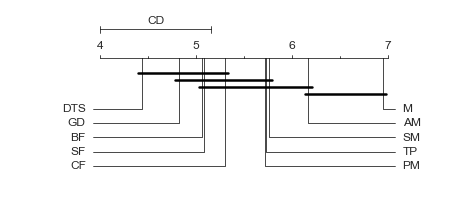

In [54]:
plot_ranks(rii2, 'DR', lowv=4, highv=7, filename='rii_dr.png', dpi=600)

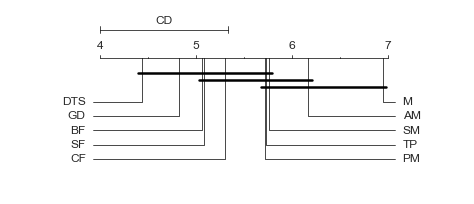

In [55]:
plot_ranks(rii2, 'DR', p=0.01, lowv=4, highv=7, filename='rii_dr_001.png', dpi=600)

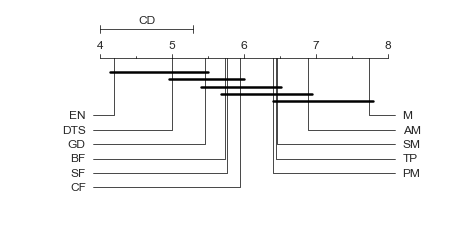

In [56]:
plot_ranks(rie2, 'DR', lowv=4, highv=8, filename='rie_dr.png', dpi=600)

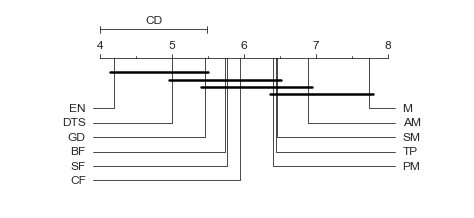

In [57]:
plot_ranks(rie2, 'DR', p=0.01, lowv=4, highv=8, filename='rie_dr_001.png', dpi=600)

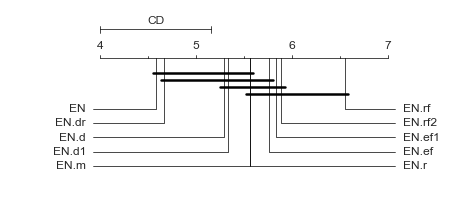

In [58]:
plot_ranks(ree2, 'DR', lowv=4, highv=7, filename='ree_dr.png', dpi=600)

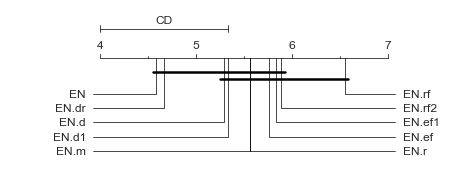

In [59]:
plot_ranks(ree2, 'DR', p=0.01, lowv=4, highv=7, filename='ree_dr_001.png', dpi=600)

In [60]:
def plot_ranks_all(rdf, p=0.05, mark=None, lowv=None, highv=None, filename=None, **kwargs):
    hows = rdf.index.levels[0]
    print(hows)
    for how in hows:
        plot_ranks(rdf, how, p, mark, lowv, highv, filename=filename.format(how), **kwargs)

In [61]:
#plot_ranks_all(rii2, lowv=4, highv=9, filename='rii2_{}.png', dpi=600)

In [62]:
#plot_ranks_all(rie2, lowv=4, highv=12, filename='rie2_{}.png', dpi=600)

In [63]:
#plot_ranks_all(ree2, lowv=4, highv=7, filename='ree2_{}.png', dpi=600)

In [64]:
#plot_ranks_all(rall2, lowv=7, highv=17, filename='rall2_{}.png', dpi=600)

In [65]:
#plot_ranks_all(rii3, lowv=4, highv=9, filename='rii3_{}.png', dpi=600)

In [66]:
#plot_ranks_all(rie3, lowv=5, highv=11, filename='rie3_{}.png', dpi=600)

In [67]:
#plot_ranks_all(ree3, lowv=4, highv=7, filename='ree3_{}.png', dpi=600)

In [68]:
#plot_ranks_all(rall3, lowv=7, highv=17, filename='rall3_{}.png', dpi=600)

Implement Nemenyi test.

In [69]:
def nemenyi(rdf, how, p=0.05, boolean=True):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    C = list(itertools.combinations(s.index, 2))
    cd = critical_difference(p, len(s), len(df))
    if boolean:
        return pd.Series({"{}-{}".format(b, a): abs(s[b] - s[a]) > cd for (a, b) in C})
    else:
        r = pd.Series({"{}-{}".format(b, a): s[b] - s[a] for (a, b) in C})
        r['critical difference'] = cd
        return r

In [70]:
def nemenyis(rdf, p=0.05, boolean=True):
    return pd.DataFrame({h: nemenyi(rdf, h, p, boolean) for h in hows})

In [71]:
nemenyi(rii2, 'DR')

AM-BF     False
AM-CF     False
AM-DTS     True
AM-GD      True
AM-PM     False
AM-SF     False
AM-SM     False
AM-TP     False
BF-CF     False
BF-GD     False
CF-GD     False
DTS-BF    False
DTS-CF    False
DTS-GD    False
M-AM      False
M-BF       True
M-CF       True
M-DTS      True
M-GD       True
M-PM       True
M-SF       True
M-SM       True
M-TP       True
PM-BF     False
PM-CF     False
PM-DTS     True
PM-GD     False
PM-SF     False
PM-SM     False
PM-TP     False
SF-BF     False
SF-CF     False
SF-DTS    False
SF-GD     False
SM-BF     False
SM-CF     False
SM-DTS     True
SM-GD     False
SM-SF     False
SM-TP     False
TP-BF     False
TP-CF     False
TP-DTS     True
TP-GD     False
TP-SF     False
dtype: bool

In [72]:
nemenyi(rii2, 'DR', boolean=False)

AM-BF                  1.103650
AM-CF                  0.870073
AM-DTS                 1.730657
AM-GD                  1.348905
AM-PM                  0.451825
AM-SF                  1.083212
AM-SM                  0.411679
AM-TP                  0.439416
BF-CF                 -0.233577
BF-GD                  0.245255
CF-GD                  0.478832
DTS-BF                -0.627007
DTS-CF                -0.860584
DTS-GD                -0.381752
M-AM                   0.775182
M-BF                   1.878832
M-CF                   1.645255
M-DTS                  2.505839
M-GD                   2.124088
M-PM                   1.227007
M-SF                   1.858394
M-SM                   1.186861
M-TP                   1.214599
PM-BF                  0.651825
PM-CF                  0.418248
PM-DTS                 1.278832
PM-GD                  0.897080
PM-SF                  0.631387
PM-SM                 -0.040146
PM-TP                 -0.012409
SF-BF                  0.020438
SF-CF   

In [73]:
nemenyis(rii2, p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,True
AM-GD,True
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [74]:
nemenyis(rii2, p=0.05, boolean=False)

,DR
AM-BF,1.103650
AM-CF,0.870073
AM-DTS,1.730657
AM-GD,1.348905
AM-PM,0.451825
AM-SF,1.083212
AM-SM,0.411679
AM-TP,0.439416
BF-CF,-0.233577
BF-GD,0.245255


DR metric indicated that DTS was significantly better than Beta. EF metric indicated that DTS was significantly better than CF and Beta. But, no metric could show significant difference between DTS and GD. Also, there was no significance reported by other five metrics at all. All tests were conducted at p=0.05 level.

In [75]:
rii2

GD   CF   BF  DTS   SF   TP   SM   PM   AM  \
how title               group                                                
DR  apple_kearneysville 0      3.6  4.6  5.2  4.2  4.0  6.2  6.6  6.6  7.6   
                        1      4.2  3.4  5.2  4.1  6.4  6.0  5.8  7.0  8.0   
                        2      5.4  4.0  4.8  4.4  5.8  7.0  6.4  7.0  4.8   
                        3      4.2  3.8  6.8  3.4  6.4  7.4  3.5  6.3  8.2   
                        4      5.0  5.4  5.8  6.0  6.0  5.6  2.7  3.2  8.2   
                        5      3.0  6.2  3.8  3.1  5.0  6.2  7.6  7.2  7.4   
                        6      3.5  6.6  5.2  4.1  4.0  4.3  8.4  7.8  6.4   
                        7      3.8  5.2  6.6  2.6  5.0  6.3  6.2  5.2  8.0   
                        8      4.6  6.6  5.8  3.0  4.0  5.4  8.2  7.6  4.8   
                        9      4.6  7.3  5.5  6.5  5.3  4.2  5.1  4.5  5.5   
                        10     3.9  7.4  3.1  5.0  3.7  4.4  7.7  7.3  6.0   
                        11     3.5  6.6  4.1  4.1  6.8  2.7  6.3  5.9  7.9   
                        12     3.9  5.9  4.3  3.1  4.1  5.9  7.5  5.9  7.3   
                        13     4.1  7.4  4.7  3.8  4.0  3.2  6.6  6.8  9.2   
                        14     2.2  8.0  3.3  3.4  4.0  5.5  8.0  8.6  5.7   
                        15     2.0  4.9  4.7  3.6  4.3  6.2  8.2  7.6  7.8   
                        16     4.2  4.8  4.2  4.6  4.6  6.0  6.6  7.8  6.4   
                        17     3.8  6.8  3.8  4.2  2.8  4.7  8.2  6.8  8.0   
                        18     4.4  5.0  5.4  4.4  5.4  4.6  5.0  5.2  7.4   
                        19     3.0  5.0  3.0  4.3  4.1  7.2  7.7  7.3  7.4   
                        20     2.6  5.6  5.4  4.2  3.6  5.4  8.0  7.6  7.2   
                        21     4.8  5.6  4.6  5.6  3.8  5.0  7.4  8.0  5.6   
    cherry_dc           0      3.0  6.1  4.7  3.6  5.3  5.1  5.2  5.4  8.8   
                        1      5.2  3.2  4.6  3.2  6.0  7.8  4.6  4.6  9.2   
    cherry_korea        0      4.8  6.8  5.2  3.2  5.2  8.0  3.6  4.6  3.8   
                        1      6.9  4.3  4.6  5.6  4.6  3.3  6.4  4.4  4.9   
                        2      6.0  3.6  4.5  5.0  4.6  5.8  6.8  6.7  4.4   
                        3      3.8  3.9  4.6  3.3  4.4  6.2  7.8  5.8  5.4   
                        4      4.2  5.4  6.4  4.0  4.6  8.4  3.6  3.2  6.0   
                        5      3.2  3.8  3.6  2.4  5.6  5.8  7.2  6.8  7.0   
...                            ...  ...  ...  ...  ...  ...  ...  ...  ...   
    pear_korea          20     5.9  4.8  4.4  4.6  6.4  7.6  4.2  4.8  3.9   
                        21     5.0  3.9  6.8  5.1  4.6  5.2  7.0  4.2  6.2   
                        22     5.0  4.2  6.2  3.8  3.2  7.2  7.2  7.6  3.0   
                        23     4.0  5.2  6.4  3.6  6.2  7.0  7.6  7.0  3.8   
                        24     5.0  2.8  5.4  4.6  6.8  7.2  6.2  5.2  4.0   
                        25     6.0  4.6  2.0  5.0  4.8  5.0  6.2  7.2  6.0   
                        26     4.2  6.6  5.6  5.0  3.4  6.2  6.4  8.6  5.0   
                        27     6.2  2.4  5.8  5.0  8.4  3.0  5.8  6.4  4.8   
                        28     4.1  6.8  5.4  7.2  4.8  3.0  4.4  5.0  5.9   
                        29     3.2  5.6  4.6  7.2  3.6  3.4  7.8  6.2  6.4   
                        30     5.1  6.4  4.4  5.7  5.0  4.3  6.6  8.4  4.4   
                        31     3.4  3.6  5.6  3.6  5.6  5.6  7.2  6.4  7.4   
                        32     3.6  5.0  6.8  3.1  6.1  6.9  4.8  5.4  6.2   
                        33     5.2  2.1  7.0  4.4  7.0  4.6  7.4  6.4  4.8   
                        34     5.8  3.8  7.6  3.0  6.2  5.6  5.6  5.8  5.0   
                        35     6.4  3.8  7.0  2.2  7.4  7.2  4.4  4.8  5.8   
                        36     5.0  4.4  5.6  4.6  4.0  6.1  5.0  4.8  7.6   
                        37     7.0  8.2  4.6  4.2  2.6  6.8  4.6  3.4  5.6   
                        38     5.2  5.8  3.9  4.9  5.8

In [76]:
nemenyis(rii2, p=0.10)

,DR
AM-BF,True
AM-CF,False
AM-DTS,True
AM-GD,True
AM-PM,False
AM-SF,True
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [77]:
nemenyis(rii2, p=0.10, boolean=False)

,DR
AM-BF,1.103650
AM-CF,0.870073
AM-DTS,1.730657
AM-GD,1.348905
AM-PM,0.451825
AM-SF,1.083212
AM-SM,0.411679
AM-TP,0.439416
BF-CF,-0.233577
BF-GD,0.245255


The ensemble model (EN) was significantly better than Beta and GD in all metrics. Three metrics, DR, EF, and EF1, reported significant difference against CF. Two metrics, D and M, reported significant difference against DTS. (p=0.05).

In [78]:
nemenyis(rie2, p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,True
AM-GD,True
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [79]:
nemenyis(rie2, p=0.05, boolean=False)

,DR
AM-BF,1.156204
AM-CF,0.945985
AM-DTS,1.885401
AM-GD,1.435036
AM-PM,0.486861
AM-SF,1.134307
AM-SM,0.432847
AM-TP,0.454015
BF-CF,-0.210219
BF-GD,0.278832


In [80]:
nemenyis(rie2, p=0.10)

,DR
AM-BF,False
AM-CF,False
AM-DTS,True
AM-GD,True
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [81]:
nemenyis(rie2, p=0.10, boolean=False)

,DR
AM-BF,1.156204
AM-CF,0.945985
AM-DTS,1.885401
AM-GD,1.435036
AM-PM,0.486861
AM-SF,1.134307
AM-SM,0.432847
AM-TP,0.454015
BF-CF,-0.210219
BF-GD,0.278832


There was no single incidence reported by all metrics that any ensemble model significantly outperformed (at p=0.05).

In [82]:
nemenyis(ree2, p=0.05)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,True
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,False


In [83]:
nemenyis(ree2, p=0.05, boolean=False)

,DR
EN.d-EN,7.021898e-01
EN.d1-EN,7.445255e-01
EN.d1-EN.d,4.233577e-02
EN.dr-EN,8.467153e-02
EN.dr-EN.d,-6.175182e-01
EN.dr-EN.d1,-6.598540e-01
EN.ef-EN,1.173723e+00
EN.ef-EN.d,4.715328e-01
EN.ef-EN.d1,4.291971e-01
EN.ef-EN.dr,1.089051e+00


In [84]:
nemenyis(ree2, p=0.10)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,True
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,True


In [85]:
nemenyis(ree2, p=0.10, boolean=False)

,DR
EN.d-EN,7.021898e-01
EN.d1-EN,7.445255e-01
EN.d1-EN.d,4.233577e-02
EN.dr-EN,8.467153e-02
EN.dr-EN.d,-6.175182e-01
EN.dr-EN.d1,-6.598540e-01
EN.ef-EN,1.173723e+00
EN.ef-EN.d,4.715328e-01
EN.ef-EN.d1,4.291971e-01
EN.ef-EN.dr,1.089051e+00


Test each dataset separately.

In [86]:
def extract(rdf, title):
    return rdf.xs(title, level='title')

In [87]:
def friedman2(rdf, how):
    titles = rdf.index.get_level_values('title').unique()
    return {t: friedman(extract(rdf, t), how) for t in titles}

In [88]:
pd.DataFrame({h: friedman2(rii2, h) for h in hows})

,DR
apple_kearneysville,"(85.5800444691, 1.24942698993e-14)"
cherry_dc,"(12.1569230769, 0.204606632217)"
cherry_korea,"(39.8499061914, 8.08933590359e-06)"
peach_korea,"(66.7747956569, 6.50791460693e-11)"
pear_korea,"(71.4338585562, 7.96468542912e-12)"


#### Kearneysville Apple

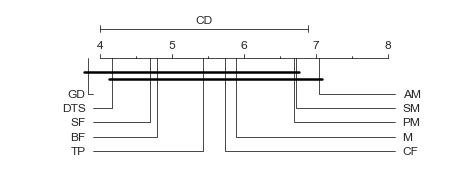

In [89]:
plot_ranks(extract(rii2, 'apple_kearneysville'), 'DR', lowv=4, highv=8, filename='rii_apple_kearneysville_dr.png', dpi=600)

In [90]:
friedmans(extract(rii2, 'apple_kearneysville'))

,DR
statistic,8.558004e+01
pvalue,1.249427e-14


In [91]:
nemenyis(extract(rii2, 'apple_kearneysville'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,True
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


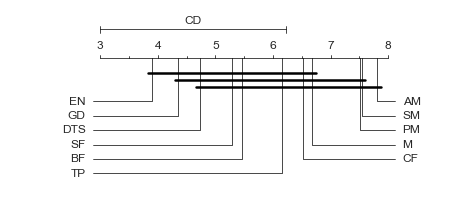

In [92]:
plot_ranks(extract(rie2, 'apple_kearneysville'), 'DR', lowv=3, highv=8, filename='rie_apple_kearneysville_dr.png', dpi=600)

In [93]:
friedmans(extract(rie2, 'apple_kearneysville'))

,DR
statistic,1.093279e+02
pvalue,7.289353e-19


In [94]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,True
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [95]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.10)

,DR
AM-BF,False
AM-CF,False
AM-DTS,True
AM-GD,True
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [96]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.20)

,DR
AM-BF,False
AM-CF,False
AM-DTS,True
AM-GD,True
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


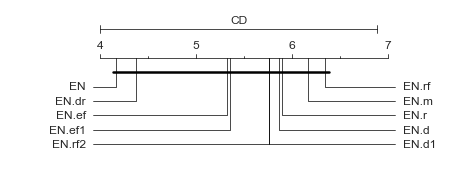

In [97]:
plot_ranks(extract(ree2, 'apple_kearneysville'), 'DR', lowv=4, highv=7, filename='ree_apple_kearneysville_dr.png', dpi=600)

In [98]:
friedmans(extract(ree2, 'apple_kearneysville'))

,DR
statistic,4.792582e+01
pvalue,2.636887e-07


In [99]:
nemenyis(extract(ree2, 'apple_kearneysville'), p=0.05)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,False
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,False


#### DC Cherry

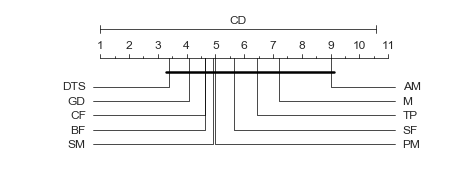

In [100]:
plot_ranks(extract(rii2, 'cherry_dc'), 'DR', lowv=1, highv=11, filename='rii_cherry_dc_dr.png', dpi=600)

In [101]:
friedmans(extract(rii2, 'cherry_dc'))

,DR
statistic,12.156923
pvalue,0.204607


In [102]:
nemenyis(extract(rii2, 'cherry_dc'))

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


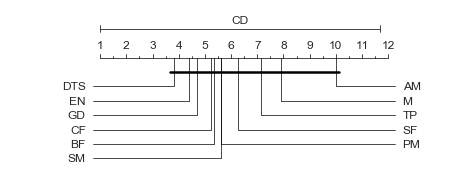

In [103]:
plot_ranks(extract(rie2, 'cherry_dc'), 'DR', lowv=1, highv=12, filename='rie_cherry_dc_dr.png', dpi=600)

In [104]:
friedmans(extract(rie2, 'cherry_dc'))

,DR
statistic,13.424658
pvalue,0.200888


In [105]:
nemenyis(extract(rie2, 'cherry_dc'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [106]:
nemenyis(extract(rie2, 'cherry_dc'), p=0.10)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


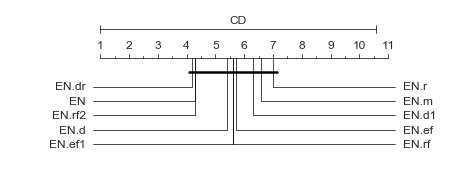

In [107]:
plot_ranks(extract(ree2, 'cherry_dc'), 'DR', lowv=1, highv=11, filename='ree_cherry_dc_dr.png', dpi=600)

In [108]:
friedmans(extract(ree2, 'cherry_dc'))

,DR
statistic,14.194444
pvalue,0.115575


In [109]:
nemenyis(extract(ree2, 'cherry_dc'), p=0.05)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,False
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,False


In [110]:
nemenyis(extract(ree2, 'cherry_dc'), p=0.10)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,False
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,False


#### Korean Cherry

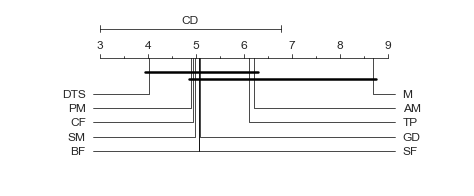

In [111]:
plot_ranks(extract(rii2, 'cherry_korea'), 'DR', lowv=3, highv=9, filename='rii_cherry_korea_dr.png', dpi=600)

In [112]:
friedmans(extract(rii2, 'cherry_korea'))

,DR
statistic,39.849906
pvalue,0.000008


In [113]:
nemenyis(extract(rii2, 'cherry_korea'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


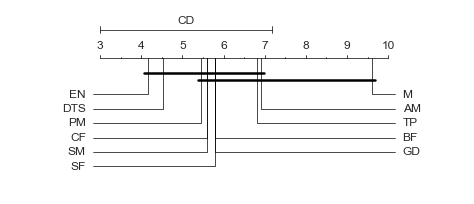

In [114]:
plot_ranks(extract(rie2, 'cherry_korea'), 'DR', lowv=3, highv=10, filename='rie_cherry_korea_dr.png', dpi=600)

In [115]:
friedmans(extract(rie2, 'cherry_korea'))

,DR
statistic,5.154063e+01
pvalue,1.387733e-07


In [116]:
nemenyis(extract(rie2, 'cherry_korea'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [117]:
nemenyis(extract(rie2, 'cherry_korea'), p=0.10)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


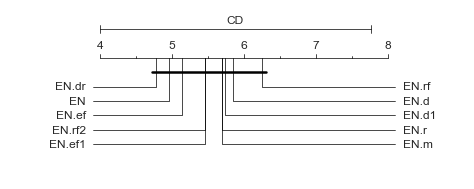

In [118]:
plot_ranks(extract(ree2, 'cherry_korea'), 'DR', lowv=4, highv=8, filename='ree_cherry_korea_dr.png', dpi=600)

In [119]:
friedmans(extract(ree2, 'cherry_korea'))

,DR
statistic,20.780350
pvalue,0.013662


In [120]:
nemenyis(extract(ree2, 'cherry_korea'), p=0.05)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,False
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,False


#### Korean Peach

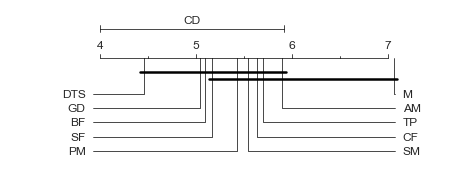

In [121]:
plot_ranks(extract(rii2, 'peach_korea'), 'DR', lowv=4, highv=7, filename='rii_peach_korea_dr.png', dpi=600)

In [122]:
friedmans(extract(rii2, 'peach_korea'))

,DR
statistic,6.677480e+01
pvalue,6.507915e-11


In [123]:
nemenyis(extract(rii2, 'peach_korea'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


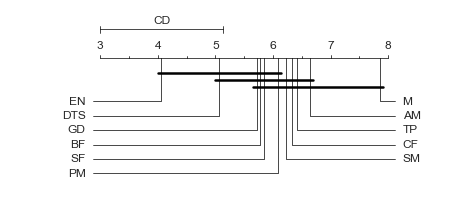

In [124]:
plot_ranks(extract(rie2, 'peach_korea'), 'DR', lowv=3, highv=8, filename='rie_peach_korea_dr.png', dpi=600)

In [125]:
friedmans(extract(rie2, 'peach_korea'))

,DR
statistic,1.289100e+02
pvalue,7.793367e-23


In [126]:
nemenyis(extract(rie2, 'peach_korea'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [127]:
nemenyis(extract(rie2, 'peach_korea'), p=0.10)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


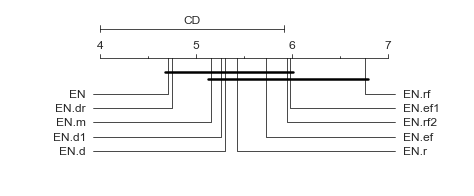

In [128]:
plot_ranks(extract(ree2, 'peach_korea'), 'DR', lowv=4, highv=7, filename='ree_peach_korea_dr.png', dpi=600)

In [129]:
friedmans(extract(ree2, 'peach_korea'))

,DR
statistic,5.461364e+01
pvalue,1.442858e-08


In [130]:
nemenyis(extract(ree2, 'peach_korea'), p=0.05)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,False
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,False


#### Korean Pear

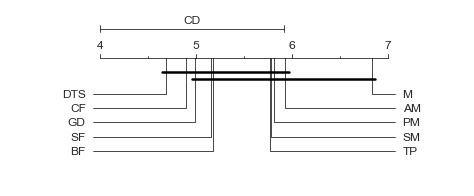

In [131]:
plot_ranks(extract(rii2, 'pear_korea'), 'DR', lowv=4, highv=7, filename='rii_pear_korea_dr.png', dpi=600)

In [132]:
friedmans(extract(rii2, 'pear_korea'))

,DR
statistic,7.143386e+01
pvalue,7.964685e-12


In [133]:
nemenyis(extract(rii2, 'pear_korea'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [134]:
nemenyis(extract(rii2, 'pear_korea'), p=0.10)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


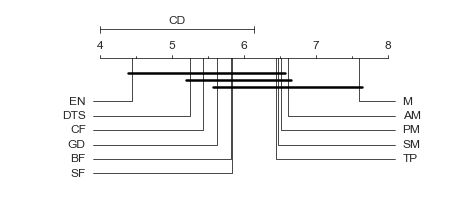

In [135]:
plot_ranks(extract(rie2, 'pear_korea'), 'DR', lowv=4, highv=8, filename='rie_pear_korea_dr.png', dpi=600)

In [136]:
friedmans(extract(rie2, 'pear_korea'))

,DR
statistic,1.110518e+02
pvalue,3.273549e-19


In [137]:
nemenyis(extract(rie2, 'pear_korea'), p=0.05)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


In [138]:
nemenyis(extract(rie2, 'pear_korea'), p=0.10)

,DR
AM-BF,False
AM-CF,False
AM-DTS,False
AM-GD,False
AM-PM,False
AM-SF,False
AM-SM,False
AM-TP,False
BF-CF,False
BF-GD,False


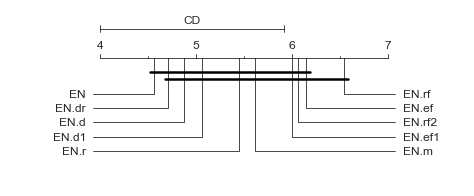

In [139]:
plot_ranks(extract(ree2, 'pear_korea'), 'DR', lowv=4, highv=7, filename='ree_pear_korea_dr.png', dpi=600)

In [140]:
friedmans(extract(ree2, 'pear_korea'))

,DR
statistic,7.734396e+01
pvalue,5.435741e-13


In [141]:
nemenyis(extract(ree2, 'pear_korea'), p=0.05)

,DR
EN.d-EN,False
EN.d1-EN,False
EN.d1-EN.d,False
EN.dr-EN,False
EN.dr-EN.d,False
EN.dr-EN.d1,False
EN.ef-EN,False
EN.ef-EN.d,False
EN.ef-EN.d1,False
EN.ef-EN.dr,False


### RMSE

In [142]:
def mean2(df):
    return df.groupby(level=[0,1,2]).mean()

In [143]:
def plot_rmse2(df, **kwargs):
    mdf = pd.melt(df.reset_index(), id_vars=['how', 'title', 'group'], var_name='Model', value_name='RMSE')
    return sns.boxplot(x='Model', y='RMSE', data=mdf, palette='Set3', width=0.3, fliersize=2, linewidth=1, **kwargs)

In [144]:
def plot_rmse3(df, **kwargs):
    mdf = pd.melt(df.reset_index(), id_vars=['how', 'title', 'seq'], var_name='Model', value_name='RMSE')
    return sns.boxplot(x='Model', y='RMSE', data=mdf, palette='Set3', width=0.3, fliersize=2, linewidth=1, **kwargs)

In [145]:
rmseii2 = mean2(load2(individuals, metrics=['rmse']))
rmseie2 = mean2(load2(individuals_with_ensemble, metrics=['rmse']))
rmseee2 = mean2(load2(ensembles, metrics=['rmse']))

In [146]:
rmseii3 = load(individuals, metrics=['rmse'])
rmseie3 = load(individuals_with_ensemble, metrics=['rmse'])
rmseee3 = load(ensembles, metrics=['rmse'])

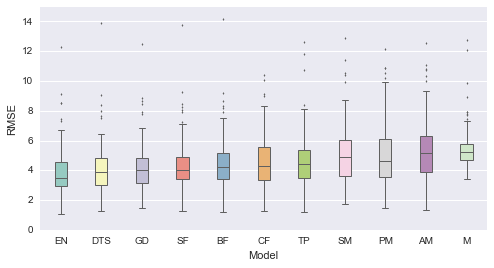

In [177]:
#sns.set(style='ticks')
plt.figure(figsize=(8,4))
ax = plot_rmse2(rmseie2, order=rmseie2.mean().sort_values().index.tolist())
ax.set_ylim((0, 15))
#sns.despine(offset=10, trim=True)
plt.savefig('rmseie2.png', dpi=600)

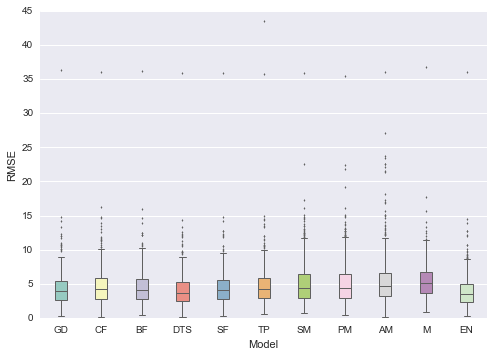

In [148]:
ax = plot_rmse3(rmseie3)